Now we are using data from real malware samples.

Can we build a classifier for the polymorphic AllAple family?

In [44]:
import pandas as pd
from sklearn import svm
from sklearn import model_selection
from sklearn import metrics
import numpy as np
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


Experiment 1: Use the CLINICAL set of AllAple (these are verified AllAple samples)

Experiment 2: Use the COMPLETE set of AllAple (everything labeled AllAple on VirusTotal)

In [51]:
raw_data = pandas.read_csv('/rodata/exercise02/total_complete.csv', index_col=None)

Split features and classes

In [52]:
learn_data = raw_data.copy()
classes = list(raw_data['class'])
del learn_data['class']

In [86]:
learn_data

,pe_FILE_HEADER_IMAGE_FILE_DLL,pe_FILE_HEADER_IMAGE_FILE_EXECUTABLE_IMAGE,pe_FILE_HEADER_NumberOfSections,pe_OPTIONAL_HEADER_BaseOfCode,pe_OPTIONAL_HEADER_BaseOfData,pe_OPTIONAL_HEADER_Subsystem,pe_OPTIONAL_HEADER_SizeOfStackCommit,pe_OPTIONAL_HEADER_SizeOfHeapCommit,pe_OPTIONAL_HEADER_SizeOfImage,pe_OPTIONAL_HEADER_MajorLinkerVersion
0,0,1,5,4096,20480,2,4096,4096,401408,6
1,0,1,3,4096,12288,2,4096,4096,131072,5
2,0,1,5,4096,20480,2,4096,4096,401408,6
3,0,1,5,4096,20480,2,4096,4096,401408,6
4,0,1,4,4096,20480,2,4096,4096,176128,5
...,...,...,...,...,...,...,...,...,...,...
478,0,1,3,1617920,2211840,2,4096,4096,2240512,8
479,0,1,3,8192,16384,2,4096,4096,32768,48
480,0,1,1,4096,12,2,4096,4096,86016,6
481,0,1,4,4096,8192,2,4096,4096,28672,1


In [9]:
# do some EDA
def quick_analysis(df):
    st = '\033[1m' + 'Data types of the dataset: ' + '\033[0m' + '\n'
    st = st + str(df.dtypes)
    st = st + '\n'
    st = st + '\033[1m' + 'Number of Rows: ' + '\033[0m' + str(df.shape[0]) + '\n'
    st = st + '\033[1m' + 'Number of Columns: ' + '\033[0m' + str(df.shape[1]) + '\n'
    st = st + '\033[1m' + 'Index Range: ' + '\033[0m' + str(len(df.index)) + '\n'
    st = st + '\033[1m' + 'Column names: ' + '\033[0m' + '\n'
    
    for name in df.columns:
        st = st + str(name +', ' + '\n')
    
    #number of null values
    nv = df.isnull().sum().sum()
    st = st + '\n'
    st = st + '\033[1m' + 'Number of null values: ' + '\033[0m' + str(nv) + '\n'
    st = st + '\033[1m' + 'Mean values: ' + '\033[0m' + str(np.mean(df)) + '\n'
    st = st + '\033[1m' + 'Standard deviations: ' + '\033[0m' + str(np.std(df)) + '\n'
    st = st + '\033[1m' + 'Absolute Average Deviation (AAD): ' + '\033[0m' + str(df.mad()) + '\n'

    return st

print(quick_analysis(learn_data))

Data types of the dataset: 
pe_FILE_HEADER_IMAGE_FILE_DLL                 int64
pe_FILE_HEADER_IMAGE_FILE_EXECUTABLE_IMAGE    int64
pe_FILE_HEADER_NumberOfSections               int64
pe_OPTIONAL_HEADER_BaseOfCode                 int64
pe_OPTIONAL_HEADER_BaseOfData                 int64
pe_OPTIONAL_HEADER_Subsystem                  int64
pe_OPTIONAL_HEADER_SizeOfStackCommit          int64
pe_OPTIONAL_HEADER_SizeOfHeapCommit           int64
pe_OPTIONAL_HEADER_SizeOfImage                int64
pe_OPTIONAL_HEADER_MajorLinkerVersion         int64
dtype: object
Number of Rows: 358
Number of Columns: 10
Index Range: 358
Column names: 
pe_FILE_HEADER_IMAGE_FILE_DLL, 
pe_FILE_HEADER_IMAGE_FILE_EXECUTABLE_IMAGE, 
pe_FILE_HEADER_NumberOfSections, 
pe_OPTIONAL_HEADER_BaseOfCode, 
pe_OPTIONAL_HEADER_BaseOfData, 
pe_OPTIONAL_HEADER_Subsystem, 
pe_OPTIONAL_HEADER_SizeOfStackCommit, 
pe_OPTIONAL_HEADER_SizeOfHeapCommit, 
pe_OPTIONAL_HEADER_SizeOfImage, 
pe_OPTIONAL_HEADER_MajorLinkerVersion, 

Number 

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


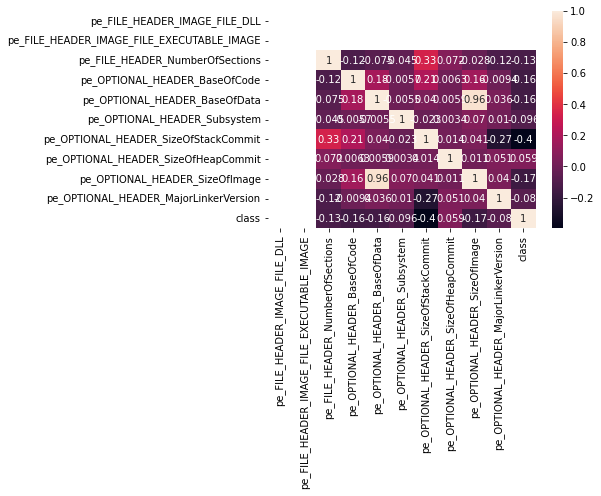

In [55]:
# get the corr matrix
corrMatrix = raw_data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [66]:
# lets standardize the data
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(learn_data)

In [57]:
np.unique(classes)


array([0, 1])

In [77]:
# Split data into training and test set
features_train, features_test, target_train, target_test = train_test_split(
    features_standardized, classes, test_size=0.2, random_state=18)

We use a Support Vector Classifier

In [78]:
classifier = svm.SVC(gamma='auto')
classifier.fit(features_train, target_train)

SVC(gamma='auto')

Let's get the predictions for the TEST data

In [79]:
predicted_classes = classifier.predict(features_test)

Q: How good are the predictions?


In [80]:
metrics.accuracy_score(target_test, predicted_classes)

0.8144329896907216

In [82]:
scores = cross_val_score(classifier, features_standardized, classes, cv =5)
np.mean(scores)

0.8572809278350515

#### Try a linear SVC classifier

In [83]:
# try LinearSVC classifier
classifier_lsvc = svm.LinearSVC(max_iter=5000)

# train the classifier with the train set
classifier_lsvc.fit(features_train, target_train)

# get the score
classifier_lsvc.score(features_test, target_test)

0.845360824742268

In [84]:
predicted_classes = classifier_lsvc.predict(features_test)
print(metrics.confusion_matrix(target_test,predicted_classes))

[[25 15]
 [ 0 57]]


In [85]:
len(features_test)

97

#### Try decisiontree classifier

[Text(0.4444444444444444, 0.9, 'pe_OPTIONAL_HEADER_BaseOfData <= -0.12\nentropy = 0.957\nsamples = 386\nvalue = [146, 240]'),
 Text(0.2222222222222222, 0.7, 'pe_OPTIONAL_HEADER_SizeOfImage <= -0.198\nentropy = 0.577\nsamples = 277\nvalue = [38, 239]'),
 Text(0.1111111111111111, 0.5, 'entropy = 0.0\nsamples = 31\nvalue = [31, 0]'),
 Text(0.3333333333333333, 0.5, 'pe_OPTIONAL_HEADER_BaseOfData <= -0.125\nentropy = 0.187\nsamples = 246\nvalue = [7, 239]'),
 Text(0.2222222222222222, 0.3, 'entropy = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(0.4444444444444444, 0.3, 'pe_FILE_HEADER_NumberOfSections <= 1.331\nentropy = 0.039\nsamples = 240\nvalue = [1, 239]'),
 Text(0.3333333333333333, 0.1, 'entropy = 0.0\nsamples = 239\nvalue = [0, 239]'),
 Text(0.5555555555555556, 0.1, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.6666666666666666, 0.7, 'pe_OPTIONAL_HEADER_BaseOfCode <= 0.091\nentropy = 0.075\nsamples = 109\nvalue = [108, 1]'),
 Text(0.5555555555555556, 0.5, 'entropy = 0.0\nsamples

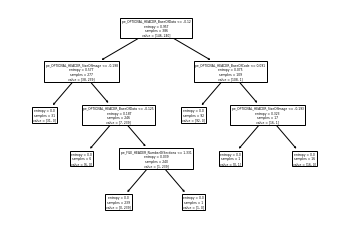

In [75]:
classifier_dt = tree.DecisionTreeClassifier(criterion= 'entropy')
classifier_dt.fit(features_train, target_train)
tree.plot_tree(classifier_dt, 
               feature_names=learn_data.columns)

In [76]:
predicted_classes = classifier_dt.predict(features_test)
classifier_dt.score(features_test, predicted_classes)


1.0